In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate

# Data importation

In [ ]:
# path to data
path = pathlib.PosixPath("../data/png_unscaled_data")

In [ ]:
# validation set percentage
valid_pct=0.2
# picture size
size = 224
# fix seed for reproducible data split
seed = 42

In [ ]:
# defines transformations that will be used to augment the training set :
# lighting is constant so not modified
# vertical flips are not meaningful as the pictures have been oriented
# horizontal flips seem to be meaningful (despite the possibility of creating mirror chromosomes)
tfms = get_transforms(max_lighting=None, do_flip=True, flip_vert=False)

In [ ]:
# preprocessing operation done to the pictures
# https://pillow.readthedocs.io/en/stable/reference/ImageOps.html
def picturePreprocessing(image):
    # converts picture to greyscale
    image = PIL.ImageOps.grayscale(image)
    # takes the negativ of the picture so that black is the background color
    image = PIL.ImageOps.invert(image)
    return image

In [ ]:
# imports a list of pictures
il = ImageList.from_folder(path, after_open=picturePreprocessing)
# splits into train/test and adds labels
src = il.split_by_rand_pct(valid_pct, seed=seed).label_from_folder()
# builds a databunch
data = ImageDataBunch.create_from_ll(src, ds_tfms=tfms, size=size, num_workers=8, resize_method=ResizeMethod.SQUISH, padding_mode='zeros').normalize(imagenet_stats)

In [ ]:
# display data to confirm that the transformation is viable
data.show_batch(rows=4)

# Training of the model

In [ ]:
# defines model
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

In [ ]:
# finds a good learning rate
learn.lr_find()
learn.recorder.plot()

In [ ]:
# defines learning rate
lr = 1e-2

In [ ]:
learn.fit_one_cycle(5, max_lr=lr)

In [ ]:
# 0.879
#learn.save("only224_freezed")

In [ ]:
learn.load("only224_freezed")
learn.unfreeze()

In [ ]:
# finds a good learning rate
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.307667,0.288303,0.915974,20:34
1,0.304907,0.289474,0.916463,20:35
2,0.287112,0.289174,0.916300,20:35
3,0.280813,0.287746,0.917474,20:35
4,0.286738,0.287846,0.916398,20:35


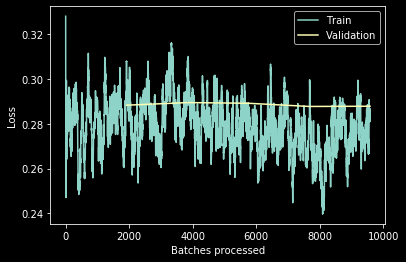

In [30]:
learn.fit_one_cycle(5, slice(3e-5, 1e-3))
learn.recorder.plot_losses()

In [ ]:
# 0.917
#learn.save("only64_unfreezed")

In [ ]:
#learn.load("only64_unfreezed")

In [ ]:
# confusion matrix of the model
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(normalize=True, figsize=(12,12), dpi=60)